The objective of this program is to be able to identify moles as cancerous or as benign based on their photo using the Kaggle dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import warnings
import tensorflow as tf
from keras.models import load_model
from glob import glob
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler 
from keras.callbacks import ReduceLROnPlateau
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
skin_meta = pd.read_csv('HAM10000_metadata.csv')
skin_meta.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [3]:
#Lesion Dictionary created for ease
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_meta['lesion'] = skin_meta['dx'].map(lesion_type.get)
skin_meta['lesion_type'] = pd.Categorical(skin_meta['lesion']).codes
skin_meta.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                           lesion  lesion_type  
0  Benign keratosis-like lesions             2  
1  Benign keratosis-like lesions             2  
2  Benign keratosis-like lesions             2  
3  Benign keratosis-like lesions             2  
4  Benign keratosis-like lesions             2

In [5]:
skin_meta['age'].fillna((skin_meta['age'].mean()), inplace=True)

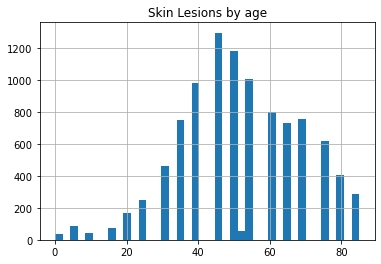

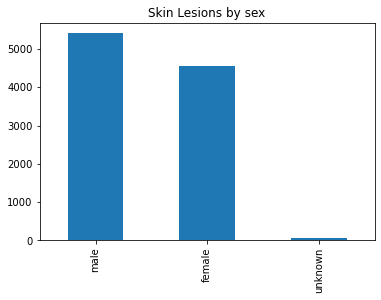

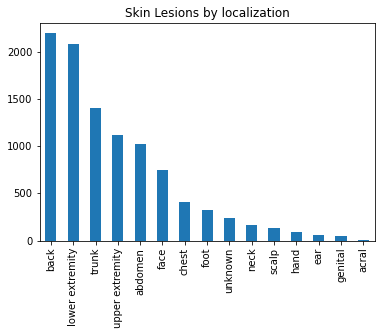

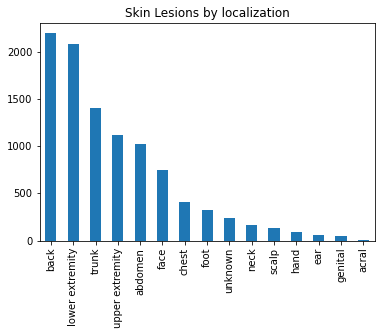

In [6]:
i = 1
for info in ['age', 'sex', 'localization', 'localization']:
    if info == 'age':
        skin_meta[info].hist(bins=40)
    else:
        skin_meta[info].value_counts().plot(kind='bar')
    plt.title('Skin Lesions by ' + info)
    i+=1
    plt.show()

In [7]:
x = []
for image in skin_meta['image_id']:
    try:
        x.append(np.asarray(Image.open('HAM10000_images_part_1/'+image+'.jpg').resize((100,75))))
    except:
        x.append(np.asarray(Image.open('HAM10000_images_part_2/'+image+'.jpg').resize((100,75))))

In [8]:
skin_meta['image']=x

In [9]:
y = skin_meta['lesion_type']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

Data Normalization

In [11]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [12]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1)

In [13]:
x_train[0].shape

(75, 100, 3)

In [14]:
#Model Parameters
input_shape = (75, 100, 3)
num_classes = 7

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100   # formulae for epochs -> input size//batch size
batch_size = 32       # taking in power of 2

from keras.callbacks import EarlyStopping
#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

In [15]:
def hist(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=2)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=2)
    return (predictions,accuracy_t,accuracy_v,accuracy)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import warnings
import tensorflow as tf
from keras.models import load_model
from glob import glob
from PIL import Image
import seaborn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler 
warnings.filterwarnings('ignore')

In [21]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, kernel_size = (3,3), input_shape = input_shape, activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(layers.Conv2D(256, kernel_size = (3,3), activation = 'relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7,activation='softmax'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 50, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 35, 48, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 23, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 23, 64)       

In [22]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Set a learning rate annealer
# applying callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

In [23]:


#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(x_train)



In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [28]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
630/630 [==============================] - 139s 221ms/step - loss: 1.1009 - accuracy: 0.6318 - val_loss: 0.9153 - val_accuracy: 0.6847
Epoch 2/50
630/630 [==============================] - 139s 220ms/step - loss: 0.9473 - accuracy: 0.6672 - val_loss: 1.6079 - val_accuracy: 0.5421
Epoch 3/50
630/630 [==============================] - 138s 220ms/step - loss: 0.9497 - accuracy: 0.6663 - val_loss: 0.8620 - val_accuracy: 0.7019
Epoch 4/50
630/630 [==============================] - 173s 274ms/step - loss: 0.9098 - accuracy: 0.6661 - val_loss: 1.0695 - val_accuracy: 0.5849
Epoch 5/50
630/630 [==============================] - 162s 257ms/step - loss: 0.9046 - accuracy: 0.6753 - val_loss: 0.8488 - val_accuracy: 0.7090
Epoch 6/50
630/630 [==============================] - 143s 227ms/step - loss: 0.8882 - accuracy: 0.6785 - val_loss: 0.8369 - val_accuracy: 0.6990
Epoch 7/50
630/630 [==============================] - 139s 221ms/step - loss: 0.8747 - accuracy: 0.6806 - val_loss: 0.7803 -

In [29]:
model.evaluate(x_test, y_test)

94/94 [==============================] - 12s 123ms/step - loss: 1.7393 - accuracy: 0.7564


[1.739262342453003, 0.7564060091972351]

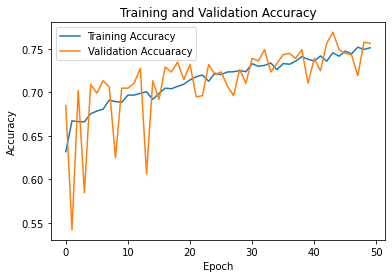

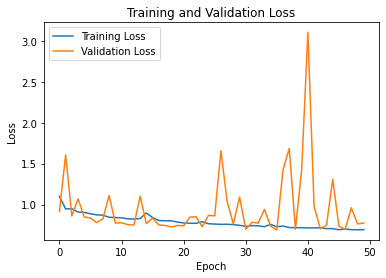

In [46]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuaracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

At this point, I think I will consider this a success on this dataset.

We can see that the validation accuracy follows the same trajectory as the the training accuracy. We also can see that the two loss patterns do not differ significantly from one another. This indicates that the model was not overfitting. Additionally, the final accuracy was over $\%75$. This is a fairly strong classifier given the complexity of the dataset and how similar each of the data points are as shown by my UMAP analysis done previously. 

In [47]:
# Fit the model
epochs = 100 
batch_size = 10
history = model.fit_generator(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/100
630/630 [==============================] - 140s 222ms/step - loss: 0.6935 - accuracy: 0.7474 - val_loss: 0.8767 - val_accuracy: 0.7504
Epoch 2/100
630/630 [==============================] - 140s 222ms/step - loss: 0.6907 - accuracy: 0.7488 - val_loss: 0.7934 - val_accuracy: 0.7432
Epoch 3/100
630/630 [==============================] - 143s 227ms/step - loss: 0.6879 - accuracy: 0.7533 - val_loss: 0.9660 - val_accuracy: 0.7104
Epoch 4/100
630/630 [==============================] - 144s 228ms/step - loss: 0.6780 - accuracy: 0.7550 - val_loss: 0.9806 - val_accuracy: 0.7361
Epoch 5/100
630/630 [==============================] - 149s 237ms/step - loss: 0.6915 - accuracy: 0.7500 - val_loss: 4.5764 - val_accuracy: 0.7504
Epoch 6/100
630/630 [==============================] - 139s 221ms/step - loss: 0.6760 - accuracy: 0.7581 - val_loss: 64.3334 - val_accuracy: 0.7518
Epoch 7/100
630/630 [==============================] - 137s 218ms/step - loss: 0.6730 - accuracy: 0.7531 - val_loss: 

630/630 [==============================] - 138s 218ms/step - loss: 0.6056 - accuracy: 0.7827 - val_loss: 0.6496 - val_accuracy: 0.7760
Epoch 57/100
630/630 [==============================] - 138s 219ms/step - loss: 0.6072 - accuracy: 0.7844 - val_loss: 22.5871 - val_accuracy: 0.7760
Epoch 58/100
630/630 [==============================] - 136s 216ms/step - loss: 0.5999 - accuracy: 0.7835 - val_loss: 0.9407 - val_accuracy: 0.7803
Epoch 59/100
630/630 [==============================] - 136s 216ms/step - loss: 0.5970 - accuracy: 0.7884 - val_loss: 1.3670 - val_accuracy: 0.7632
Epoch 60/100
630/630 [==============================] - 137s 217ms/step - loss: 0.5947 - accuracy: 0.7844 - val_loss: 1.4258 - val_accuracy: 0.7789
Epoch 61/100
630/630 [==============================] - 140s 222ms/step - loss: 0.5956 - accuracy: 0.7868 - val_loss: 0.7231 - val_accuracy: 0.7389
Epoch 62/100
630/630 [==============================] - 139s 220ms/step - loss: 0.5940 - accuracy: 0.7876 - val_loss: 0.6746

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuaracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

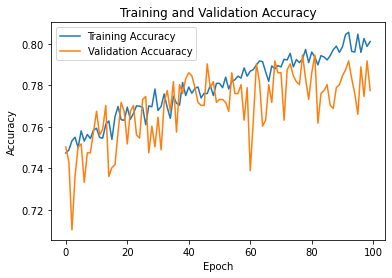

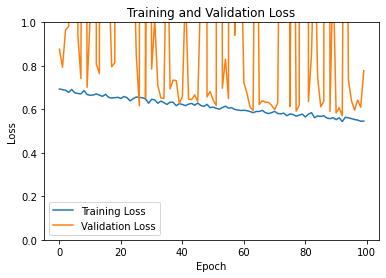

In [49]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuaracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.ylim(0,1)
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [50]:
model.evaluate(x_test, y_test)

94/94 [==============================] - 11s 122ms/step - loss: 0.7518 - accuracy: 0.7943


[0.7518367171287537, 0.7943427562713623]

That really is incredible. After running for 100 additional epochs, I was able to attain near %80 on my test set. That is quite an astounding thing to reach, while this may be slightly overfitted now (It is not as clearly not overfit as before) it still retains amazing classification ability.